In [50]:
import json
import csv

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [51]:
btc_data_path  = "data/BCHAIN-MKPRU_refine.csv"
gold_data_path = "data/LBMA-GOLD_refine.csv"
sns.set()

# Data

In [52]:
btc_data  = pd.read_csv(btc_data_path).rename(columns={ 'Date': 'date', 'Value': 'btc' })
gold_data = pd.read_csv(gold_data_path).rename(columns={ 'Date': 'date', 'USD': 'gold' })

<AxesSubplot:xlabel='date'>

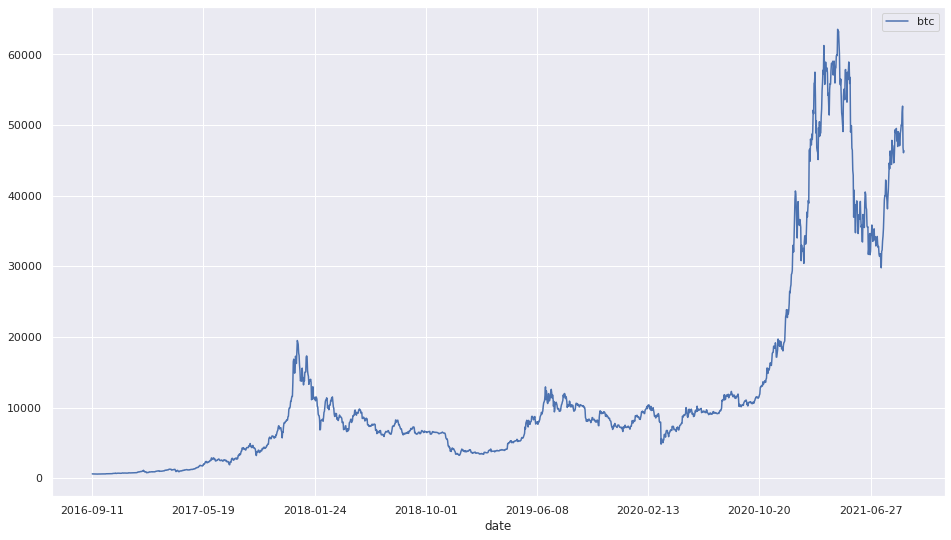

In [53]:
btc_data.set_index('date').plot(figsize=(16, 9))

<AxesSubplot:xlabel='date'>

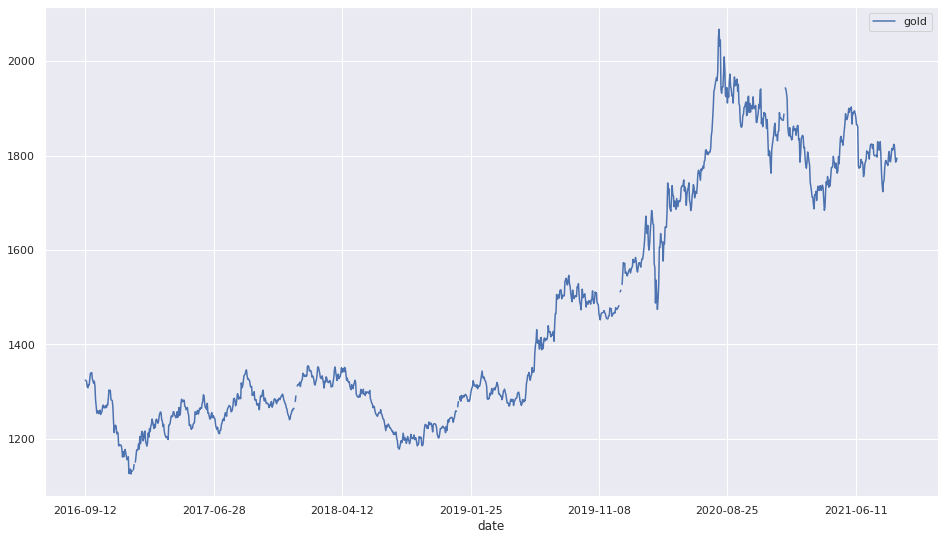

In [54]:
gold_data.set_index('date').plot(figsize=(16, 9))

## Data Processing

### Data Merge

In [55]:
data = pd.merge(left=btc_data, right=gold_data, how='left')
data.insert(data.shape[1], 'btc_tradable', True)
data.insert(data.shape[1], 'gold_tradable', ~np.asarray(data['gold'].isna()))

### Interpolation of Gold Prices

In [56]:
gold_inter = data.gold.interpolate(method='pad')
gold_inter[0] = gold_inter[1]

data.insert(data.shape[1] - 1, 'gold_inter', gold_inter)

### Calculation of Diffs

In [57]:
data.insert(data.shape[1], 'btc_diff', data['btc'].diff())
data.insert(data.shape[1], 'gold_diff', data['gold_inter'].diff())

# data['btc_diff'][0] = 0
# data['gold_diff'][0] = 0

### Setting Index

In [58]:
tdi = pd.DatetimeIndex(data.date)
data.set_index(tdi, inplace=True)
data.drop(columns=['date'], inplace=True)

In [59]:
data.to_csv("data/data.csv")
data

,btc,gold,btc_tradable,gold_inter,gold_tradable,btc_diff,gold_diff
date,,,,,,,
2016-09-11,621.65,NaN,True,1324.60,False,NaN,NaN
2016-09-12,609.67,1324.60,True,1324.60,True,-11.98,0.00
2016-09-13,610.92,1323.65,True,1323.65,True,1.25,-0.95
2016-09-14,608.82,1321.75,True,1321.75,True,-2.10,-1.90
2016-09-15,610.38,1310.80,True,1310.80,True,1.56,-10.95
...,...,...,...,...,...,...,...
2021-09-06,51769.06,1821.60,True,1821.60,True,1821.68,-2.10
2021-09-07,52677.40,1802.15,True,1802.15,True,908.34,-19.45
2021-09-08,46809.17,1786.00,True,1786.00,True,-5868.23,-16.15


## Seasonal Decomposition

## We first run a 

In [60]:
gold_decomposed = sm.tsa.seasonal_decompose(data.gold_inter)
btc_decomposed = sm.tsa.seasonal_decompose(data.btc)

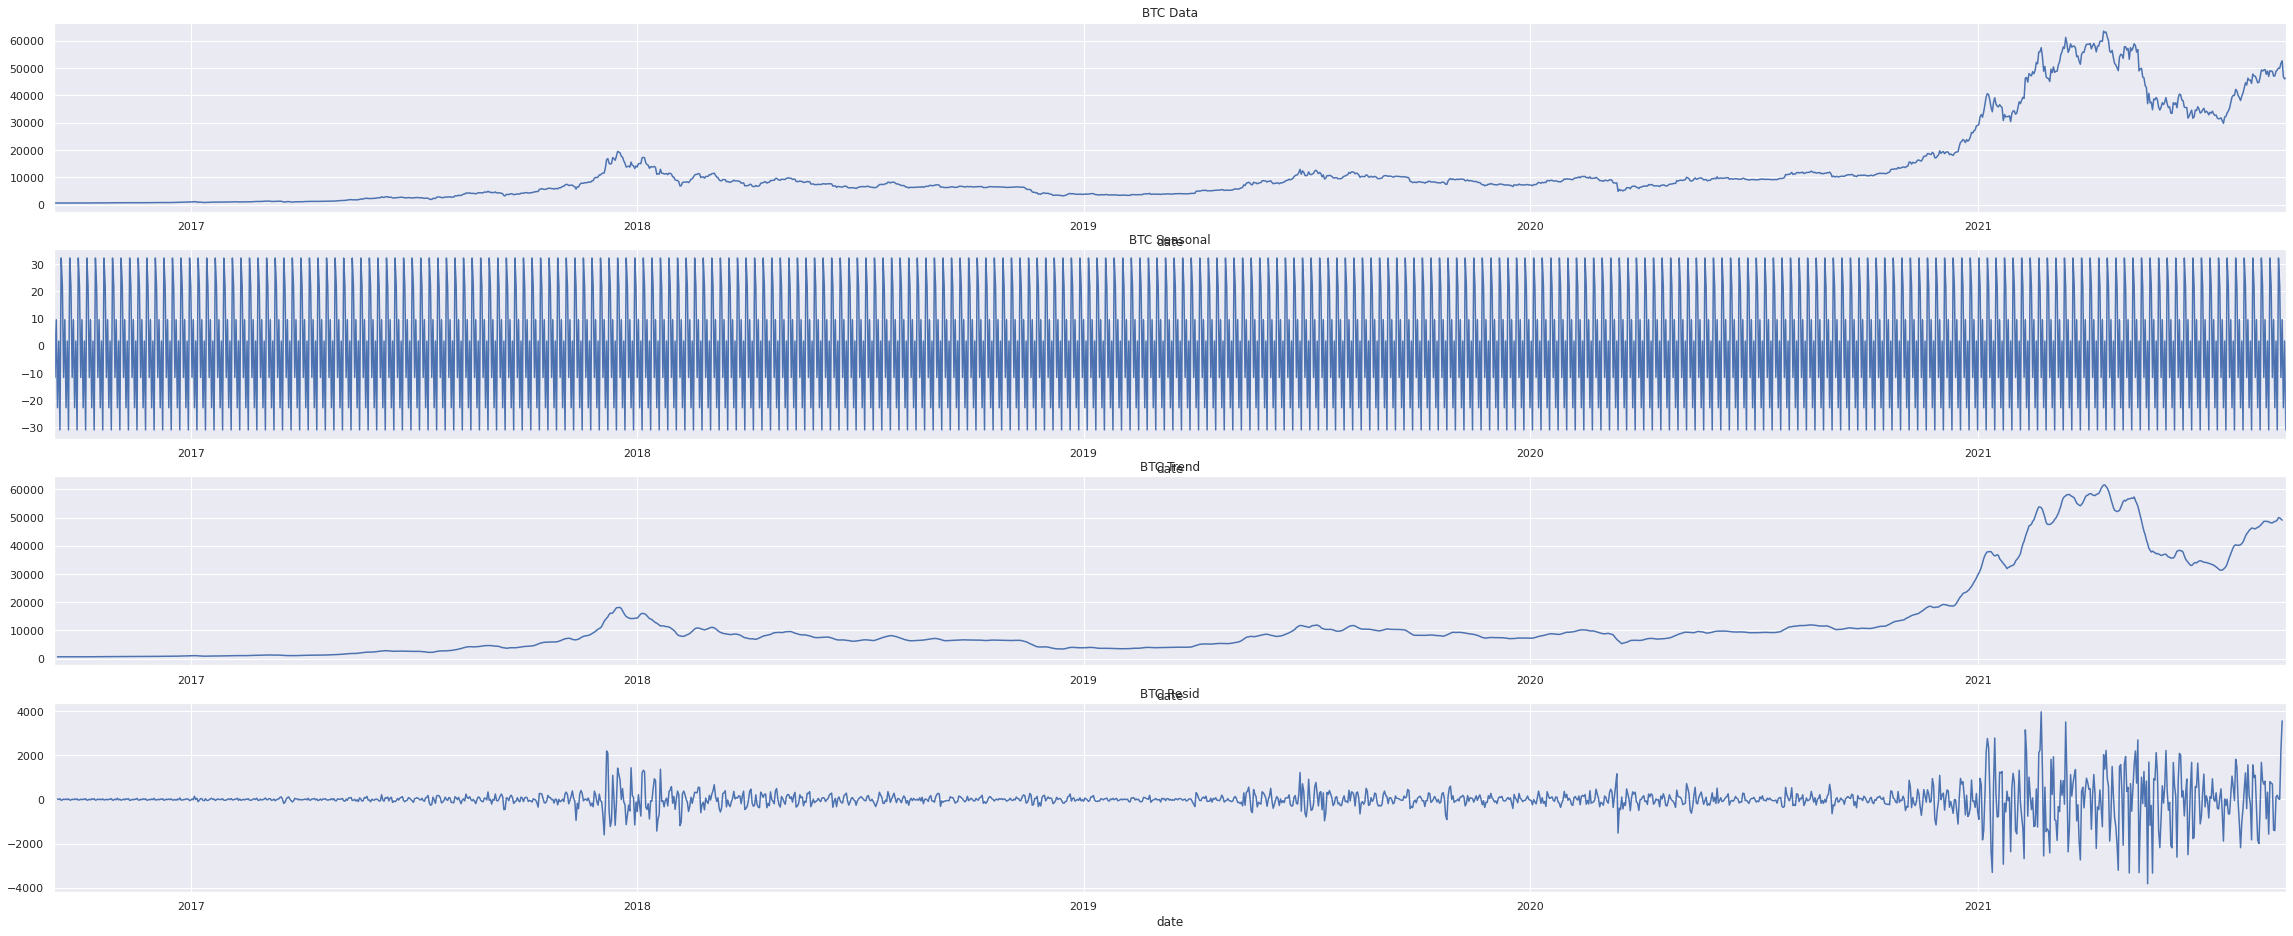

In [61]:
plt.figure(figsize=(40, 16))

plt.subplot(411)
plt.title("BTC Data")
data.btc.plot()

plt.subplot(412)
plt.title("BTC Seasonal")
btc_decomposed.seasonal.plot()

plt.subplot(413)
plt.title("BTC Trend")
btc_decomposed.trend.plot()

plt.subplot(414)
plt.title("BTC Resid")
btc_decomposed.resid.plot()

plt.savefig("data/tsa/btc.pdf")

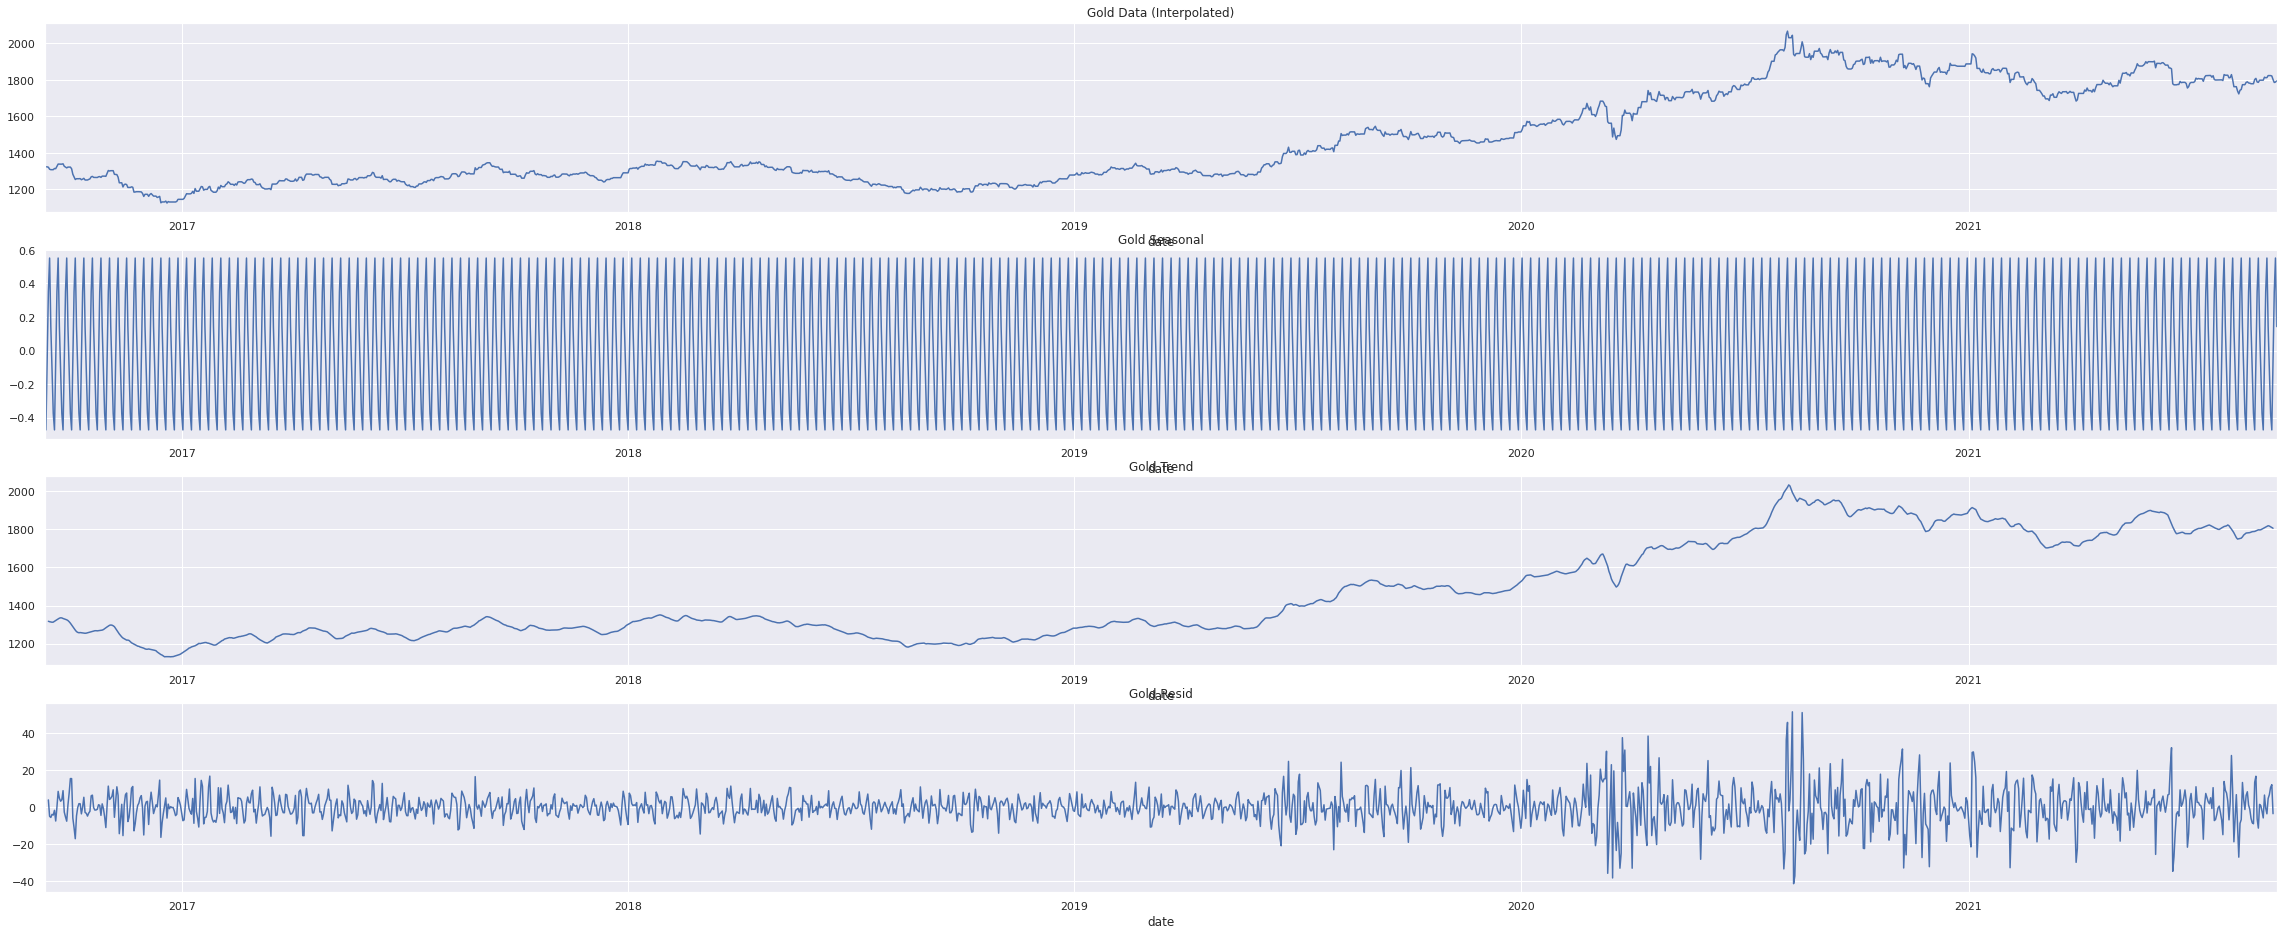

In [62]:
plt.figure(figsize=(40, 16))

plt.subplot(411)
plt.title("Gold Data (Interpolated)")
data.gold_inter.plot()

plt.subplot(412)
plt.title("Gold Seasonal")
gold_decomposed.seasonal.plot()

plt.subplot(413)
plt.title("Gold Trend")
gold_decomposed.trend.plot()

plt.subplot(414)
plt.title("Gold Resid")
gold_decomposed.resid.plot()

plt.savefig("data/tsa/gold_itp.pdf")

# Generated Sequence

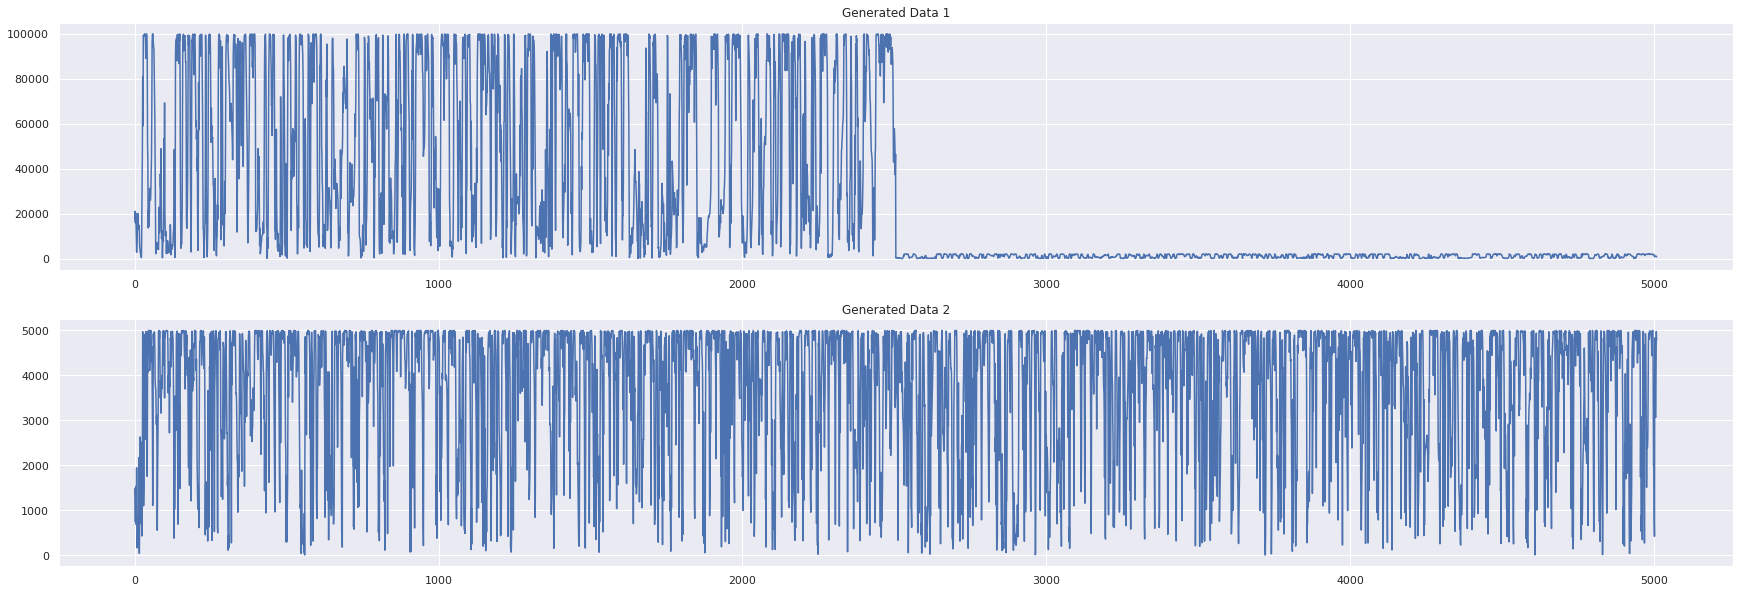

In [63]:
btc_gen_df = pd.read_csv("data/btc.csv")
gold_gen_df = pd.read_csv("data/gold.csv")
btc_gen = torch.from_numpy(btc_gen_df.to_numpy().transpose((-1, -2)))[1]
gold_gen = torch.from_numpy(gold_gen_df.to_numpy().transpose((-1, -2)))[1]
plt.figure(figsize=(30, 10))

plt.subplot(211)
plt.title("Generated Data 1")
plt.plot(btc_gen)
plt.subplot(212)
plt.title("Generated Data 2")
plt.plot(gold_gen)

plt.savefig("data/seq_gen.pdf")

In [64]:
data_gen = btc_gen_df.copy()
data_gen.insert(gold_gen_df.shape[1], 'gold', pd.DataFrame(data=gold_gen_df, columns=['gld']))
data_gen.insert(gold_gen_df.shape[1], 'gold_inter', pd.DataFrame(data=gold_gen_df, columns=['gld']))
data_gen

,idx,btc,gold_inter,gold
0,0,17346.944136,1480.257346,1480.257346
1,1,21030.983983,1267.168092,1267.168092
2,2,15901.666422,741.200065,741.200065
3,3,20233.615892,1531.201512,1531.201512
4,4,16077.903337,1122.077295,1122.077295
...,...,...,...,...
5005,5005,1132.553906,3102.235423,3102.235423
5006,5006,1117.704485,3068.141154,3068.141154
5007,5007,979.205691,4232.022115,4232.022115
5008,5008,761.607707,4977.981100,4977.981100


In [65]:
data_gen.to_csv("data/data_gen.csv")